In [ ]:
!pip install japanize-matplotlib &>/dev/null # 日本語フォントをダウンロードする。
from matplotlib import pylab as plt
import japanize_matplotlib
plt.rcParams["figure.dpi"]=140

import numpy as np
import pandas as pd

from pprint import pprint as pprint

In [ ]:
# MaxdIはdI緊急事態宣言発令の閾値．報告数．人口十万人あたり
# lockdownrateは緊急事態宣言時の接触数割合((1-lockdownrate)の割合だけS・I接触を削減する)
# V,dVはワクチン接種済み人口，ワクチン接種数

def calcSIR(data,MaxdI=float('inf'),lock_down_limit_rate=0):
    N=data.N
    S=data.S
    I=data.I
    R=data.R
    V=data.V
    C=data.C
    dI=data.dI
    dR=data.dR
    dS=data.dS
    dV=data.dV
    dC=data.dC
    KAPPA=data.KAPPA
    LAMBDA=data.LAMBDA
    GAMMA=data.GAMMA
    NUM_OF_DAYS=data.NUM_OF_DAYS
    BETA=np.copy(data.BETA)
    lockdownBETA=np.copy(data.BETA)*(1-lock_down_limit_rate)

    count_nonzero_dv=0
    print("NUM_OF_DAYS=",NUM_OF_DAYS)
    for t in range(1,NUM_OF_DAYS): #t日目について
        dV.append(dV[-1])
        #Sが0マイナスになりそうな世代のdV[-1]を0に．再度正規化し，当初の傾きを維持する
        if(np.any((S[-1]+dS[-1])<0)):
            print("(S[-1]+dS[-1])<=0:S[-1]=",S[-1])
            print("(S[-1]+dS[-1])<=0:dV[-1]=",dV[-1])
            print("(S[-1]+dS[-1])<=0:dS[-1]=",dS[-1])
        dV[-1][(S[-1]+dS[-1])<0]=0

        # dV更新時
        if(count_nonzero_dv!=np.count_nonzero(dV[-1])):
            count_nonzero_dv=np.count_nonzero(dV[-1])
            if(0<np.sum(dV[-1])):
                dV[-1]=dV[-1]/np.sum(dV[-1])*np.sum(dV[0])

        dR.append(GAMMA*I[-1]+LAMBDA*C[-1])
        dC.append(KAPPA*I[-1]-LAMBDA*C[-1])
        dI.append(BETA*np.sum(I[-1],axis=0)*S[-1]-GAMMA*I[-1]-KAPPA*I[-1])#-(4,2)-(4,2)=>(4,2) #年齢方向に合計
        dS.append(-BETA*np.sum(I[-1],axis=0)*S[-1]-dV[-1])#(4,1)*(4,2)=>(4,2)．(4,2)*(4,2)=>(4,2)

        #Sがそれでも負になるとき
        if(np.any((S[-1]+dS[-1])<0)):
            #ちょうど0になるように
            dS[-1][(S[-1]+dS[-1])<0]=-S[-1][(S[-1]+dS[-1])<0]
            dI[-1][(S[-1]+dS[-1])<0]=-dR[-1]+KAPPA[(S[-1]+dS[-1])<0]*I[-1][(S[-1]+dS[-1])<0]+S[-1][(S[-1]+dS[-1])<0]
            print("dI[-1][(S[-1]+dS[-1])<0]",dI[-1][(S[-1]+dS[-1])<0])
            print("-dR[-1]+KAPPA[(S[-1]+dS[-1])<0]",-dR[-1]+KAPPA[(S[-1]+dS[-1])<0])
            print("I[-1][(S[-1]+dS[-1])<0]",I[-1][(S[-1]+dS[-1])<0])

        #Iが負になるとき
        if(np.any((I[-1]+dI[-1])<0)):
            dI[-1][(I[-1]+dI[-1])<0]=-I[-1][(I[-1]+dI[-1])<0]
        if(np.any((I[-1]+dI[-1])<0)):
            dR[-1][(I[-1]+dI[-1])<0]+=I[-1][(I[-1]+dI[-1])<0]

        if(np.any((S[-1]+dS[-1])<0)):
            print("(S[-1]+dS[-1])<=0:修正後S[-1]=",S[-1])
            print("(S[-1]+dS[-1])<=0:修正後dS[-1]=",dS[-1])
            print("(S[-1]+dS[-1])<=0:修正後dV[-1]=",dV[-1])

        s=S[-1]+dS[-1]
        i=I[-1]+dI[-1]
        r=R[-1]+np.sum(dR[-1],axis=1,keepdims=True)
        S.append(s)
        #S.append(np.where(0 < s, s, 0))
        I.append(i)
        #I.append(np.where(0 < i, i, 0))
        R.append(np.where(0 < r, r, 0))
        V.append(V[-1]+dV[-1])
        C.append(C[-1]+dC[-1])
        
        #"if(np.isinf(S[-1]).any() and np.isinf(I[-1]).any() and np.isinf(R[-1]).any() and np.isinf(V[-1]).any()):
        if(False):
            print("dS["+str(t)+"]=",dS[-1])
            print("dI["+str(t)+"]=",dI[-1])
            print("dR["+str(t)+"]=",dR[-1])
            print("dV["+str(t)+"]=",dV[-1])
            
            print("np.sum(dR["+str(t)+"],axis=1)+R[-1]=",np.sum(dR[-1],axis=1,keepdims=True)+R[-1])
            print("S["+str(t)+"]",S[-1])
            print("I["+str(t)+"]",I[-1])
            print("R["+str(t)+"]",R[-1])
            print("V["+str(t)+"]",V[-1])
        
        if(MaxdI/1000000*sum(N)<abs(sum(dI[-1]))):
            BETA=lockdownBETA
        else:
            BETA=data.BETA
        
        if(np.any(I[-1]<0)):
            print("break: any(I["+str(t)+"]<=0)")
            print("I["+str(t)+"]",I[-1])
            break
        if(np.any(S[-1]<0)):
            print("break: any(S["+str(t)+"]<=0)")
            print("S["+str(t)+"]",S[-1])
            print("dS["+str(t)+"]",dS[-1])
            break
        if(np.any(R[-1]<0)):
            print("break: any(R["+str(t)+"]<=0)")
            print("R["+str(t)+"]",R[-1])
            break

    return data


In [66]:
class Data:
    def __init__(self,omega0=None,label=None):
        self.NUM_OF_DAYS=120
        self.GROUPS=["0-9","10-19","20-29","30-39","40-40","50-59","60-69","70-79","80-89","90-99","100-"]
        
        self.ZERO=np.array([[0], # <10
                    [0], # 10-19
                    [0], # 20-29
                    [0], # 30
                    [0], # 40
                    [0], # 50
                    [0], # 60
                    [0], # 70
                    [0], # 80
                    [0], # 90
                    [0]])# >100
        self.label=label

        #回復率
        #self.GAMMA=np.array([[1/15.7,1/15.7]])．γ=1/(感染者の平均回復日数)とすることができるらしいので．回復日数を15.7日として
        #self.GAMMA=np.array([[1/5]]) #回復率．γ=1/(感染から隔離されるまでの日数)とすることができるらしいので．
        #self.GAMMA=self.GAMMA/len(self.GAMMA) #11区分
        self.GAMMA=np.array([[0.38946]])#(1-GAMMA)^14=0.001

        self.R0=np.array([[1.1]])
        #1.32倍（95％信頼区間1.28-1.37）https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/10279-covid19-40.html
        #0.94 (95%信頼区間 0.90-0.97)，1.23 (95%信頼区間 1.18-1.28)

        #https://www.bousai.metro.tokyo.lg.jp/_res/projects/default_project/_page_/001/013/860/47kai/2021052704.pdf
        self.N=np.array([[524939+499632], # 0-9
                    [493559+566729], # 10-19
                    [753698+863678], # 20-29
                    [969877+1038390], # 30
                    [1154214+1048170], # 40
                    [891332+722755], # 50
                    [725312+854575], # 60
                    [713342+583971], # 70
                    [449314+261441], # 80
                    [108999+28732], # 90
                    [5142]])# >=100

        # 罹患率10万人あたり https://datastudio.google.com/u/0/reporting/c1dfbd03-0aa7-457d-81d2-3ca5be34706b/page/KNtNB?s=mM99TXFS68A
        # 「同性同世代10万人あたり何人感染しているか。……かかりやすさを比較」
        self.ALPHA=np.array([[413.05+399.74], # 0-9
                        [871.69+749.47], # 10-19
                        [2551.66+2330.63], # 20-29
                        [1821.6+1268.86], # 30
                        [1336.05+842.52], # 40
                        [1249.87+922.23], # 50
                        [945.98+655.33], # 60
                        [748.8+566.84], # 70
                        [952.52+804.37], # 80
                        [1393.54+1336.56], # 90
                        [2597.4+1582.82]])# >=100

        self.ALPHA=self.ALPHA/np.sum(self.ALPHA)
        
        self.BETA=self.R0*self.GAMMA*self.ALPHA #BETA=R0*GAMMA (R0の定義より)
        self.BETA=self.BETA/self.N

        #ワクチン接種速度[/day]．Nと同じ形の行列np.array()で年齢別に設定．
        # 全人口に対する割合で設定していある(`*(1/100)*np.sum(N)`の部分)．
        self.OMEGA=np.array([[0], # <10
                    [0], # 10-19
                    [0], # 20-29
                    [0], # 30
                    [0], # 40
                    [0], # 50
                    [0.5], # 60
                    [1], # 70
                    [1], # 80
                    [1], # 90
                    [1]])# >=100
        self.OMEGA=self.OMEGA*self.N #/np.sum(N)
        if(0<np.sum(self.OMEGA)):
            self.OMEGA=self.OMEGA/np.sum(self.OMEGA)
        self.OMEGA=self.OMEGA*(0.6/100)*np.sum(self.N) #1%/day
        #self.OMEGA=self.OMEGA*(1/100)*np.sum(self.N) #1%/day

        self.dV=[np.copy(self.OMEGA)]

        # 重症化率．大阪から
        # ちなみに大阪5/23-以降の全年齢の重症化率K(t)=C(t)/I(t-1)=0.6617624%
        self.KAPPA=np.array([
                    [0.8], # <10
                    [0.8], # 10-19
                    [0.8], # 20-29
                    [0.8], # 30
                    [0.8], # 40
                    [6.43], # 50
                    [6.43], # 60
                    [10.55], # 70
                    [4.98], # 80
                    [4.98], # 90
                    [4.98]])# >=100
        self.KAPPA=1-(self.KAPPA*(1/100)) #[%]→対I割合．
        self.KAPPA=1-self.KAPPA**(1/10)
        if(np.average(self.KAPPA)<np.average(self.GAMMA)):
            print("self.KAPPA",self.KAPPA)
            print("<self.GAMMA",self.GAMMA)
            self.GAMMA=self.GAMMA-self.KAPPA
        else:
            print("self.GAMMA",self.GAMMA)
            print("<self.KAPPA",self.KAPPA)
            self.KAPPA=self.KAPPA-self.GAMMA

        #重症者の退院率
        self.LAMBDA=np.copy(self.ZERO)+(1-0.5**(1/14)) #(1-LAMBDA)^14=0.5 ⇒ LAMBDA=1-0.5^(1/14)半減期14日のつもり

        self.S=[np.copy(self.N)]

        # 年齢別感染者数/全感染者 東京都 直近1週間 5/18-5/24
        #【感染状況】①-2 新規陽性者数（年代別）より
        self.I=[4710*self.ALPHA]
        self.R=[np.copy(self.ZERO)]
        self.V=[np.copy(self.ZERO)]
        self.C=[np.copy(self.ZERO)] #critical
        self.dS=[np.copy(self.ZERO)]
        self.dI=[np.copy(self.ZERO)]
        self.dR=[np.copy(self.ZERO)]
        self.dC=[np.copy(self.ZERO)] #critical

        if(omega0 is not None):
            self.OMEGA=omega0
            self.OMEGA=self.OMEGA*self.N
            if(0<np.sum(self.OMEGA)):
                self.OMEGA=self.OMEGA/np.sum(self.OMEGA)
            self.OMEGA=self.OMEGA*(1/100)*np.sum(self.N) #1%/day
            self.dV=[np.copy(self.OMEGA)]

        # R0=β/γ
        print("N=",self.N)
        print("np.sum(N)=",np.sum(self.N))
        print("γ=",self.GAMMA)

        print("α=",self.ALPHA)
        print("sum(α)=",np.sum(self.ALPHA))

        print("β=γR0*α=",self.BETA*sum(self.N))
        print("sum(β)=",np.sum(self.BETA*self.N))
        print("β/N=",self.BETA)

        print("κ=",self.KAPPA)
        print("(大阪5/23-以降の重症化率K(t)=C(t)/I(t-1)=0.6617624)")
        print("sum(κ)/len(κ)=",np.sum(self.KAPPA)/len(self.KAPPA))
        print("重症者の退院率λ=",self.LAMBDA)

        print("1日のワクチン率(vs.N)Ω=",self.OMEGA)
        print("sum(Ω)=",np.sum(self.OMEGA))

        print("dV[0]=",self.dV[0])
        print("sum(dV[0])=",sum(self.dV[0]))
        print("validation sum(dV[0])/sum(N)=",np.sum(self.dV[0])/np.sum(self.N))


data2=Data(omega0=np.array([[0], # <10
    [0], # 10-19
    [0], # 20-29
    [0], # 30
    [0], # 40
    [0], # 50
    [0], # 60
    [0], # 70
    [0], # 80
    [0], # 90
    [0]]),# >=100
    label="接種なし"
    )
data2=calcSIR(data2)
data1=Data(label="0.6%/day接種")
data1=calcSIR(data1)


self.KAPPA [[0.00080289]
 [0.00080289]
 [0.00080289]
 [0.00080289]
 [0.00080289]
 [0.006624  ]
 [0.006624  ]
 [0.01108712]
 [0.00509525]
 [0.00509525]
 [0.00509525]]
<self.GAMMA [[0.38946]]
N= [[1024571]
 [1060288]
 [1617376]
 [2008267]
 [2202384]
 [1614087]
 [1579887]
 [1297313]
 [ 710755]
 [ 137731]
 [   5142]]
np.sum(N)= 13257801
γ= [[0.38865711]
 [0.38865711]
 [0.38865711]
 [0.38865711]
 [0.38865711]
 [0.382836  ]
 [0.382836  ]
 [0.37837288]
 [0.38436475]
 [0.38436475]
 [0.38436475]]
α= [[0.03085584]
 [0.06154388]
 [0.18534573]
 [0.11732272]
 [0.08270476]
 [0.08245914]
 [0.06079032]
 [0.04994547]
 [0.06669658]
 [0.10364242]
 [0.15869314]]
sum(α)= 1.0
β=γR0*α= [[1.71049708e-01]
 [3.29676566e-01]
 [6.50876545e-01]
 [3.31808662e-01]
 [2.13287066e-01]
 [2.90160920e-01]
 [2.18542262e-01]
 [2.18664531e-01]
 [5.32979729e-01]
 [4.27398406e+00]
 [1.75288373e+02]]
sum(β)= 0.428406
β/N= [[1.29018159e-08]
 [2.48666099e-08]
 [4.90938539e-08]
 [2.50274281e-08]
 [1.60876654e-08]
 [2.18860519e-08]

In [68]:
# plot
def plot(d):
    T=range(0,d.NUM_OF_DAYS)
    print("NUM_OF_DAYS",d.NUM_OF_DAYS)
    print("len(S)",len(d.S))

    #plt.plot([sum(r) for r in d.R], label="R", linewidth=.5)
    #plt.plot([sum(i) for i in d.I], label="I", linewidth=.5)
    plt.plot([sum(c) for c in d.C], label="C", linewidth=.5)
    plt.plot([sum(di) for di in d.dR], label="-dR", linewidth=.5)
    plt.plot([sum(dc) for dc in d.dC], label="dC", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    plt.plot([sum(s) for s in d.S], label="S", linewidth=.5)
    plt.plot([sum(i) for i in d.dI], label="dI", linewidth=.5)
    plt.plot([sum(v) for v in d.V], label="V(+全人口の1%/day)", linewidth=.5)
    plt.plot([sum(c) for c in d.C], label="C", linewidth=.5)
    plt.plot([sum(d.C[t])+sum(d.I[t]) for t in T], label="CI", linewidth=.5)
    plt.plot([sum(d.S[t])+sum(d.I[t])+sum(d.R[t])+sum(d.V[t]) for t in T], label="SICRV", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    plt.plot([sum(d.I[t]) for t in T], label="I", linewidth=.5)
    plt.plot([sum(d.I[t])+sum(d.C[t]) for t in T], label="IC", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for k, age in enumerate(d.GROUPS):
        plt.plot([r[k][0] for r in d.R], label="R"+str(age), linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for k, age in enumerate(d.GROUPS):
        plt.plot([d.N[k]-v[k][0] for v in d.V], label="N-V"+str(age), linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for k, age in enumerate(d.GROUPS):
        plt.plot([s[k][0]/d.N[k] for s in d.S], label="S"+str(age), linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("当該年齢層の人口に占める割合[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()


print("vactinated")
#plot(data1)
print("no vactine")
#plot(data2)


vactinated
no vactine


NUM_OF_DAYS 120
len(S) 120


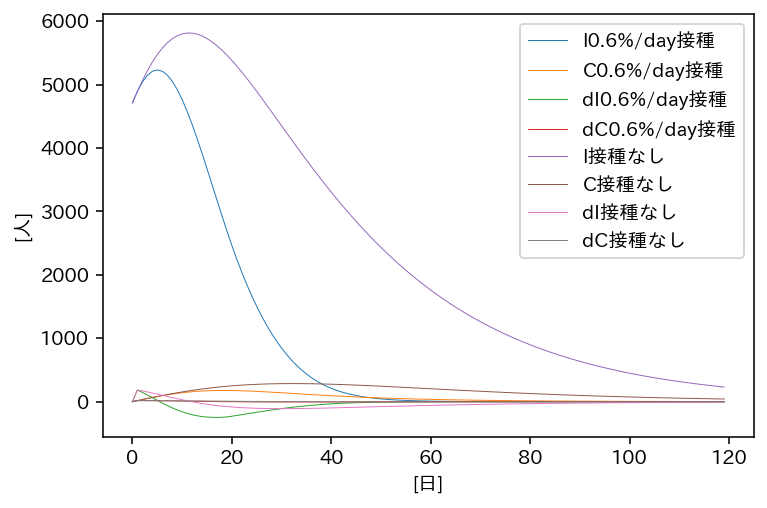

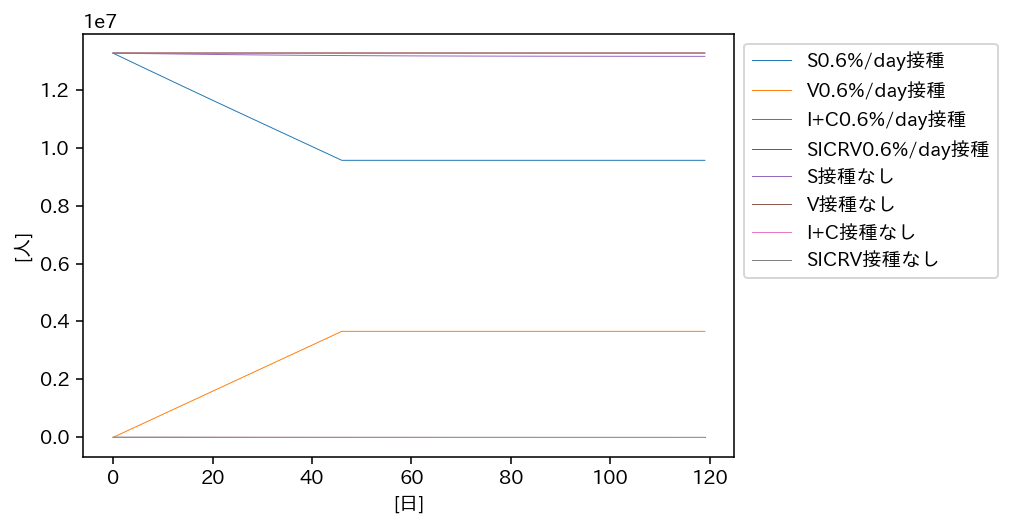

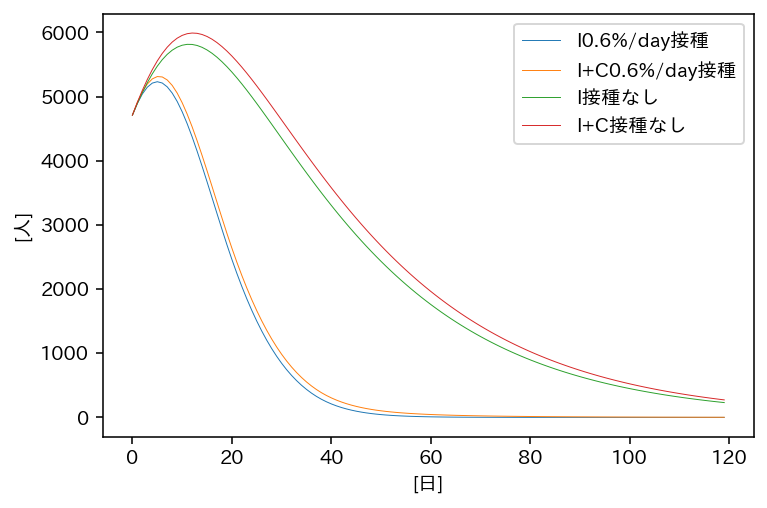

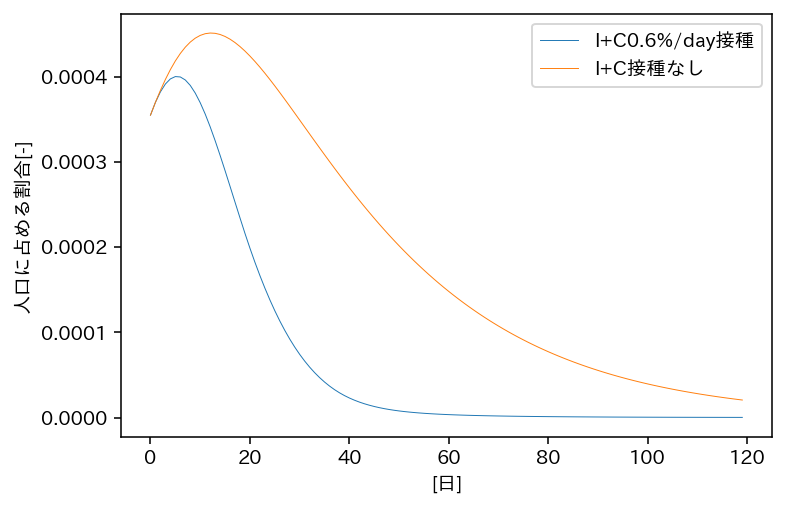

In [69]:
# plot
def plotdiff(ds):
    T=range(0,ds[0].NUM_OF_DAYS)
    print("NUM_OF_DAYS",ds[0].NUM_OF_DAYS)
    print("len(S)",len(ds[0].S))

    for i, d in enumerate(ds):
        plt.plot([sum(i) for i in d.I], label="I"+d.label, linewidth=.5)
        plt.plot([sum(c) for c in d.C], label="C"+d.label, linewidth=.5)
        plt.plot([sum(di) for di in d.dI], label="dI"+d.label, linewidth=.5)
        plt.plot([sum(dc) for dc in d.dC], label="dC"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot([sum(s) for s in d.S], label="S"+d.label, linewidth=.5)
        plt.plot([sum(v) for v in d.V], label="V"+d.label, linewidth=.5)
        plt.plot([sum(d.C[t])+sum(d.I[t]) for t in T], label="I+C"+d.label, linewidth=.5)
        plt.plot([sum(d.S[t])+sum(d.I[t])+sum(d.R[t])+sum(d.V[t]) for t in T], label="SICRV"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot([sum(d.I[t]) for t in T], label="I"+d.label, linewidth=.5)
        plt.plot([sum(d.I[t])+sum(d.C[t]) for t in T], label="I+C"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot([(sum(d.C[t])+sum(d.I[t]))/sum(d.N) for t in T], label="I+C"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("人口に占める割合[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

plotdiff([data1,data2])
